# Assignment Lab 5 - Nicolas Duboc

In [1]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

******************************
context imported. Front of path:
/Users/zuni/repos/numeric_2024
back of path: /Users/zuni/miniconda3/envs/numeric_2024/lib/python3.12/site-packages
******************************

through /Users/zuni/repos/numeric_2024/notebooks/lab5/context.py


# Problem Initial

### part 1

In [2]:
class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return temp_w, temp_b, temp_e

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1] 
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi) 
        f[1] = y[1] * (beta_b * bare - user.chi)
        
        return f

In [3]:
theSolver1 = Integ54('adapt.yaml')
timevals1, yvals1, errorlis1t = theSolver1.timeloop5fixed()


In [3]:
# higher black daisy fraction
theSolver1 = Integ54('initial1.yaml')
timevals1, yvals1, errorlis1t = theSolver1.timeloop5fixed()
daisies1 = pd.DataFrame(yvals1, columns=['white', 'black'])

temp_w1 = []
temp_b1 = []
temp_e1 = []
for i in range(len(timevals1)):
    w1,b1,e1 = theSolver1.find_temp(yvals1[i,:])
    temp_w1.append(w1- 273.15)
    temp_b1.append(b1- 273.15)
    temp_e1.append(e1- 273.15)

In [4]:
# 0 black daisy fraction
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

temp_w = []
temp_b = []
temp_e = []
for i in range(len(timevals)):
    w,b,e = theSolver.find_temp(yvals[i,:])
    temp_w.append(w- 273.15)
    temp_b.append(b- 273.15)
    temp_e.append(e- 273.15)

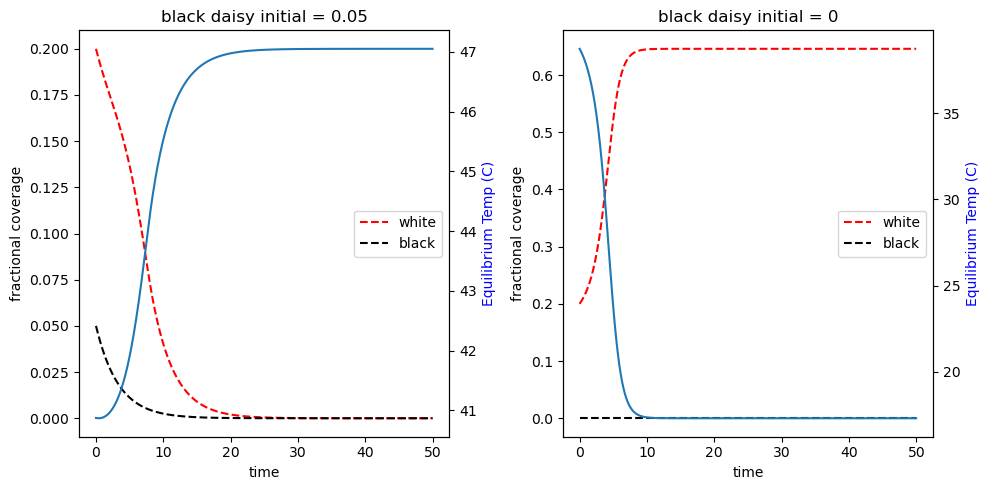

In [5]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(timevals1,daisies1['white'],linestyle='--', color='r', label='white')
ax1.plot(timevals1, daisies1['black'],linestyle='--', color='k', label='black')
ax1.set_title('black daisy initial = 0.05')
ax1.set_xlabel('time')
ax1.set_ylabel('fractional coverage')
ax1.legend(loc='center right')
ax3 = ax1.twinx()
ax3.plot(timevals,temp_e1,label='equilibirum')
ax3.set_ylabel('Equilibrium Temp (C)',color='blue')

ax2.plot(timevals, daisies['white'],linestyle='--', color='r', label='white')
ax2.plot(timevals, daisies['black'],linestyle='--', color='k', label='black')
ax2.set_title('black daisy initial = 0')
ax2.set_xlabel('time')
ax2.set_ylabel('fractional coverage')
ax2.legend(loc='center right')
ax4 = ax2.twinx()
ax4.plot(timevals,temp_e,label='equilibirum')
ax4.set_ylabel('Equilibrium Temp (C)',color='blue')


fig.tight_layout()

The left column plots above represent the scenario where the initial black daisy population is 5%. The right column plots represent the scenario where the initial black daisy population is 0.


In the scenario with an initial black daisy coverage of 0, the equilibrium temperature decreases. This is consistent with a higher population of white daisies; since their albedo is much higher, the equilibrium temperature will decrease with a high fractional coverage. Despite the decrease, however, the temperature reaches a steady state slightly higher than 0C, allowing the white daisies to reach a non-zero steady state. 

In the scenario with a 5% coverage of black daisies, the equilibrium temperature increases. This is consistent given the lower albedo of black daisies, allowing more of the solar radiation to warm up the planet and increasing the equilibrium temperature. The fractional coverage of both white and black daisies goes to zero in this scenario. We can see the reason from this in the temperature plot; a greater coverage of black daisies increases the initial equilibrium temperature to be above 40C, with the presence of black daisies, this temperature increases, essentially killing all black daisies almost immediately. The white daisies reflect some of the sunlight away but eventually die off as the temperature increases. This case does give a non-zero steady state as temperatures get too high for any daisy to survive.


### part 2 


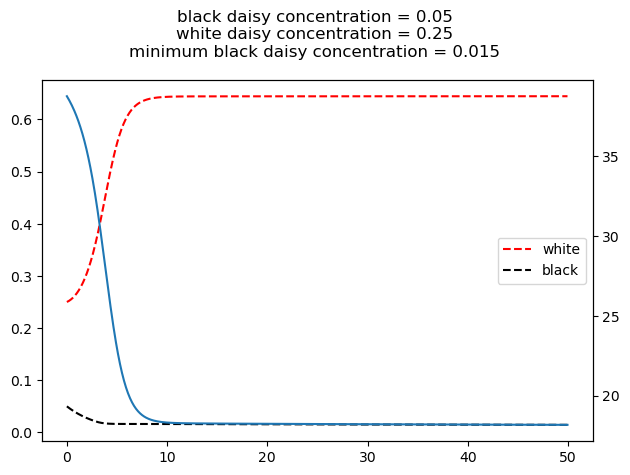

In [6]:
# constant blackconc, varying whiteconc for steady state
theSolver2 = Integ54('initial2.yaml')
timevals2, yvals2, errorlist2 = theSolver2.timeloop5fixed()
daisies2 = pd.DataFrame(yvals2, columns=['white', 'black'])

temp_w2 = []
temp_b2 = []
temp_e2 = []
for i in range(len(timevals)):
    w2,b2,e2 = theSolver2.find_temp(yvals2[i,:])
    temp_w2.append(w2- 273.15)
    temp_b2.append(b2- 273.15)
    temp_e2.append(e2- 273.15)

fig, ax1 = plt.subplots(1,1)
ax1.plot(timevals2,daisies2['white'],'--r',label='white')
ax1.plot(timevals2,daisies2['black'],'--k',label='black')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(timevals2,temp_e2)

fig.suptitle(f'black daisy concentration = 0.05\nwhite daisy concentration = 0.25\nminimum black daisy concentration = {round(np.min(daisies2['black']),3)}')

fig.tight_layout()




In order to get a non-zero steady state the fraction of white daisy needs to be increased by at least 0.1. The plot above depicts the initial concentration of white daisies of 0.25, in order to allow the black daisy concentration to reach a minimum of 1.5% coverage. The higher initial concentration of white daisies "overwrites" the impact of the initial black daisy concentration. This allows the temperature cool instead of warm, allowing white daisies to grow to an equilibrium. The initial presence of black daisies keeps the temperature high enough to allow a small concentration of black daisies to continue to grow. 

### Part 3

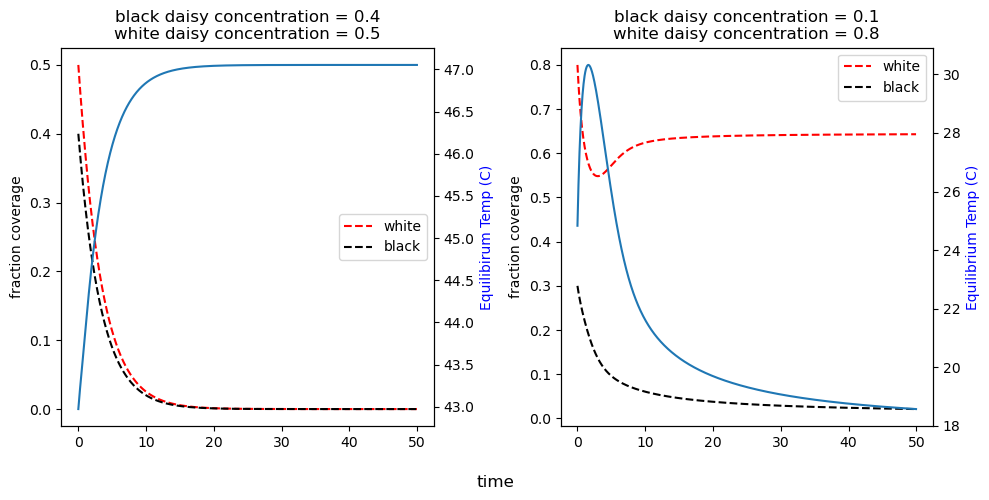

In [7]:
# blackconc = 0.25 whiteconc = 0.25
theSolver3 = Integ54('initial3.yaml')
timevals3, yvals3, errorlist3 = theSolver3.timeloop5fixed()
daisies3 = pd.DataFrame(yvals3, columns=['white', 'black'])

temp_w3 = []
temp_b3 = []
temp_e3 = []
for i in range(len(timevals)):
    w3,b3,e3 = theSolver3.find_temp(yvals3[i,:])
    temp_w3.append(w3- 273.15)
    temp_b3.append(b3- 273.15)
    temp_e3.append(e3- 273.15)

theSolver4 = Integ54('initial4.yaml')
timevals4, yvals4, errorlist4 = theSolver4.timeloop5fixed()
daisies4 = pd.DataFrame(yvals4, columns=['white', 'black'])

temp_w4 = []
temp_b4 = []
temp_e4 = []
for i in range(len(timevals)):
    w4,b4,e4 = theSolver4.find_temp(yvals4[i,:])
    temp_w4.append(w4- 273.15)
    temp_b4.append(b4- 273.15)
    temp_e4.append(e4- 273.15)

fig, (ax1,ax3) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(timevals3,daisies3['white'],'--r',label='white')
ax1.plot(timevals3,daisies3['black'],'--k',label='black')
ax1.legend(loc='center right')
ax1.set_title('black daisy concentration = 0.4\nwhite daisy concentration = 0.5')
ax1.set_ylabel('fraction coverage')

ax2 = ax1.twinx()
ax2.plot(timevals3,temp_e3)
ax2.set_ylabel('Equilibirum Temp (C)',color='blue')



ax3.plot(timevals4,daisies4['white'],'--r',label='white')
ax3.plot(timevals4,daisies4['black'],'--k',label='black')
ax3.legend()
ax3.set_title('black daisy concentration = 0.1\nwhite daisy concentration = 0.8')
ax3.set_ylabel('fraction coverage')

ax4 = ax3.twinx()
ax4.plot(timevals4,temp_e4)
ax4.set_ylabel('Equilibrium Temp (C)',color='blue')

fig.supxlabel('time')
fig.tight_layout()



The left plot above shows a scenario where the white fractional coverage is greater than that of the black daisies. This has an interesting effect on the equilibrium temperature; the corresponding fractional coverage of black daisies is such that the temperature increases rapidly. As it continues to increase and reach a steady state, both black and white daisies die off due to the high temperatures.

The plot on the right shows a similar scenario to the first case but the gap of white to black daisies is much greater. In this case, the equilibrium temperature increases due to the presence of black daisies, however, the greater concentration of white daisies cools the temperature such that a different steady state is reached. 

These two cases descibe the behavior of the equilibrium temperature and its dependence on the initial fraction of white and black daisies. 

# Problem adaptive

### part 1 

In [4]:
theSolver = Integ54('adapt.yaml')
a_timeVals, a_yVals, a_errorList = theSolver.timeloop5Err()

Text(0.5, 1.0, 'size of timesteps')

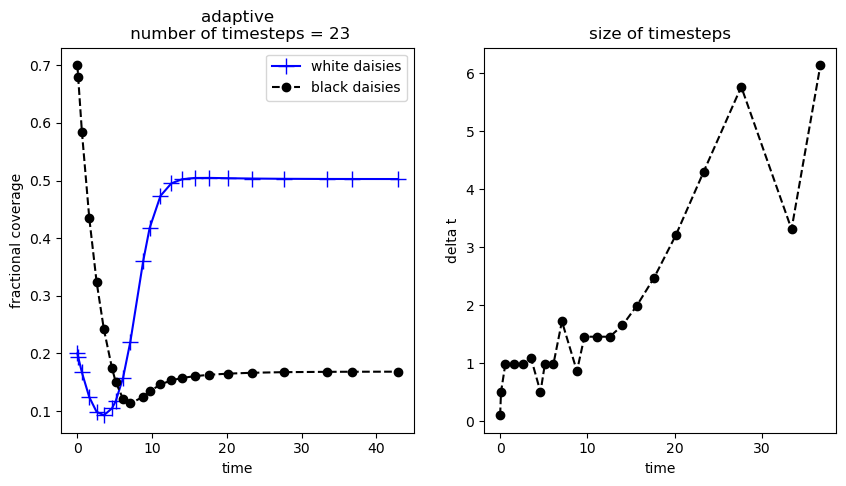

In [8]:
theSolver = Integ54('adapt.yaml')
a_timeVals, a_yVals, a_errorList = theSolver.timeloop5Err()

a_yvals = pd.DataFrame.from_records(a_yVals, columns=['white', 'black'])

thefig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

points, = ax1.plot(a_timeVals, a_yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = ax1.plot(a_timeVals, a_yvals['black'], '--ko', label='black daisies')
ax1.set_title(f'adaptive\n number of timesteps = {len(a_timeVals)}')
ax1.set_xlabel('time')
#ax2 = theAx.twiny()
#ax2.plot(np.diff(a_timeVals))
ax1.set_ylabel('fractional coverage')
ax1.legend(loc='best')

ax2.plot(a_timeVals[:-1],np.diff(a_timeVals),'--ko')
ax2.set_ylabel('delta t')
ax2.set_xlabel('time')
ax2.set_title('size of timesteps')

### part 2

Text(0.5, 0.98, 'size of timesteps between adaptive and fixed')

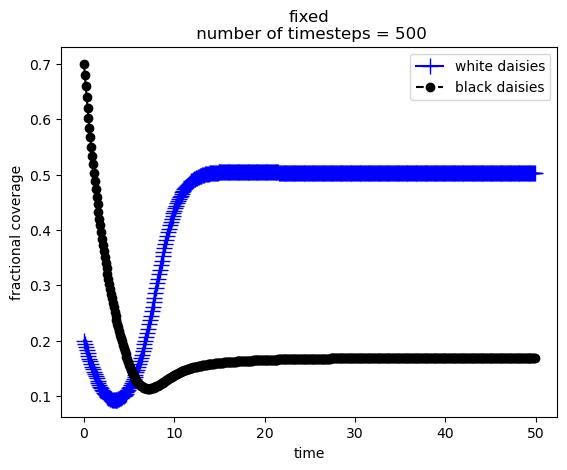

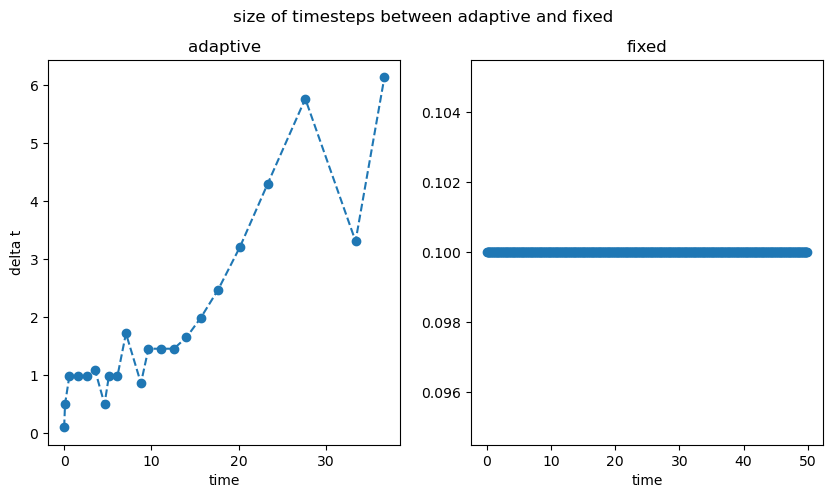

In [9]:
f_timeVals, f_yVals, f_errorList = theSolver.timeloop5fixed()

f_yvals = pd.DataFrame.from_records(f_yVals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(f_timeVals, f_yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(f_timeVals, f_yvals['black'], '--ko', label='black daisies')
theAx.set_title(f'fixed\n number of timesteps = {len(f_timeVals)}')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(a_timeVals[:-1],np.diff(a_timeVals),'--o')
ax1.set_title('adaptive')
ax1.set_ylabel('delta t')
ax1.set_xlabel('time')

ax2.plot(f_timeVals,[0.1 for i in range(len(f_timeVals))],'--o')
ax2.set_title('fixed')
ax2.set_xlabel('time')

fig.suptitle('size of timesteps between adaptive and fixed')

The adaptive time steps takes significantly less steps than its fixed counterpart. The size of steps is larger in areas where the slope is zero or constant and smaller in places with varying slopes.

### Part 3
The fixed timestep algorithm completes the simulation with 500 timesteps. Conversely the adaptive algorithm finished the same simulation but with 23 timesteps. This means the fixed timestep algorithm would need to be 95% faster in order to give the same performance as the adaptive timeloop. The solutions for the adaptive timestep are close, if not almost identical to the solutions for the fixed timestep. In this case, an adaptive timestep improves our computation time and maintains the accuracy of the fixed timestep. It is unlikely that the fixed timestep will be 95% faster as it is limited by the number of steps that the simulation needs to run. A fixed timestep algorithm could, in theory, be as fast as the adaptive timestep by decreasing the size of the timestep in the simulation. The downside to this, however, that too large a timestep might cause errors in accuracy, especially in areas where the slope is not zero or constant. 

# Problem Predator

### part 1

In [16]:
class Integ54_rabbits(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc,self.initvars.rabbitconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return temp_w, temp_b, temp_e

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of rabbits if using rabbits.yaml
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y[:2])
        
        # daisy growth rate is still determined by the temperature 
        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)

        ### Modified equations here ###
        
        # daisy death rate will be goverened by rabbit population
        f[0] = y[0] * (beta_w * bare - y[2])
        f[1] = y[1] * (beta_b * bare - y[2])
        
        # now add rabbits 
        # growth rate = determined by fractional coverage of both daisies. 
        # death rate = user defined (rabchi)
        f[2] = y[2] * ((y[0]+y[1]) - (user.rabchi))
        
        return f

### part 2

In [17]:
rabSolver = Integ54_rabbits('rabbits.yaml')
r_timeVals, r_yvals, r_errorList = rabSolver.timeloop5Err()

eTemp = [] 
for i in range(len(r_timeVals)):
    dont, care, e = rabSolver.find_temp(r_yvals[i,:2])
    eTemp.append(e-273.15)

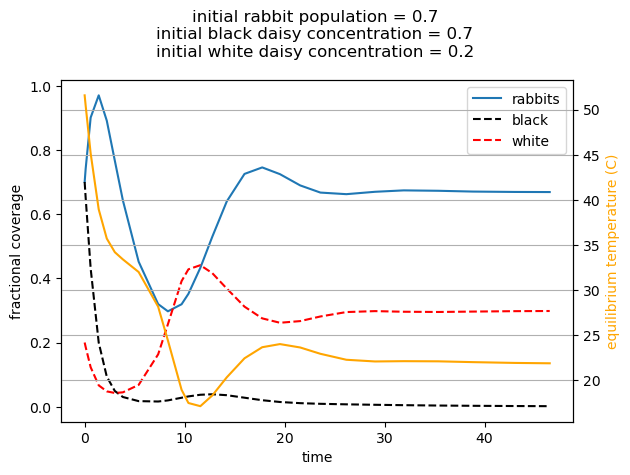

In [18]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(r_timeVals,r_yvals[:,2],label='rabbits')
ax1.plot(r_timeVals,r_yvals[:,1],'--k',label='black')
ax1.plot(r_timeVals,r_yvals[:,0],'--r',label='white')
ax1.legend()
ax1.set_ylabel('fractional coverage')
ax1.set_xlabel('time')

ax2 = ax1.twinx()

ax2.plot(r_timeVals,eTemp,color='orange')
ax2.set_ylabel('equilibrium temperature (C)',color='orange')
ax2.grid()

fig.suptitle('initial rabbit population = 0.7\ninitial black daisy concentration = 0.7\ninitial white daisy concentration = 0.2')
fig.tight_layout()


### part 3


In [19]:
rabSolver1 = Integ54_rabbits('rabbits1.yaml')
r_timeVals1, r_yvals1, r_errorList1 = rabSolver1.timeloop5Err()

eTemp1 = [] 
for i in range(len(r_timeVals1)):
    w1, b1, e1 = rabSolver.find_temp(r_yvals1[i,:2])
    eTemp1.append(e1-273.15)

rabSolver2 = Integ54_rabbits('rabbits2.yaml')
r_timeVals2, r_yvals2, r_errorList2 = rabSolver2.timeloop5Err()
eTemp2 = [] 
for i in range(len(r_timeVals2)):
    w2, b2, e2 = rabSolver2.find_temp(r_yvals2[i,:2])
    eTemp2.append(e2-273.15)

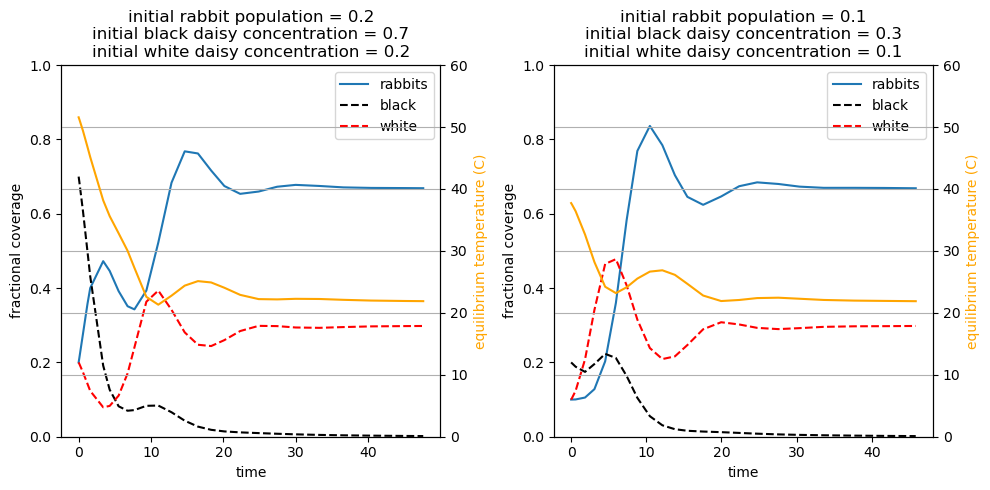

In [20]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(r_timeVals1,r_yvals1[:,2],label='rabbits')
ax1.plot(r_timeVals1,r_yvals1[:,1],'--k',label='black')
ax1.plot(r_timeVals1,r_yvals1[:,0],'--r',label='white')
ax1.legend()
ax1.set_ylabel('fractional coverage')
ax1.set_xlabel('time')
ax1.set_title('initial rabbit population = 0.2\ninitial black daisy concentration = 0.7\ninitial white daisy concentration = 0.2')
ax1.set_ylim(0,1)

ax2 = ax1.twinx()
ax2.plot(r_timeVals1,eTemp1,color='orange')
ax2.set_ylabel('equilibrium temperature (C)',color='orange')
ax2.grid()
ax2.set_ylim(0,60)

ax3.plot(r_timeVals2,r_yvals2[:,2],label='rabbits')
ax3.plot(r_timeVals2,r_yvals2[:,1],'--k',label='black')
ax3.plot(r_timeVals2,r_yvals2[:,0],'--r',label='white')
ax3.legend()
ax3.set_ylabel('fractional coverage')
ax3.set_xlabel('time')
ax3.set_title('initial rabbit population = 0.1\ninitial black daisy concentration = 0.2\ninitial white daisy concentration = 0.1')
ax3.set_ylim(0,1)

ax4 = ax3.twinx()
ax4.plot(r_timeVals2,eTemp2,color='orange')
ax4.set_ylabel('equilibrium temperature (C)',color='orange')
ax4.grid()
ax4.set_ylim(0,60)


fig.tight_layout()

The plots above show two different scenarios with different concentrations of daisies and bunnies. Although the initial conditions in both scenarios are different, in both cases the population of rabbits, daisies, and the equilibirum temperature reach the same steady state. The population of rabbits determine the death rate of the daisies, the daisies in turn have an effect on the temperature. This feedback loop allows the system to reach the same equilibrium regardless of initial conditions. 

### part 4

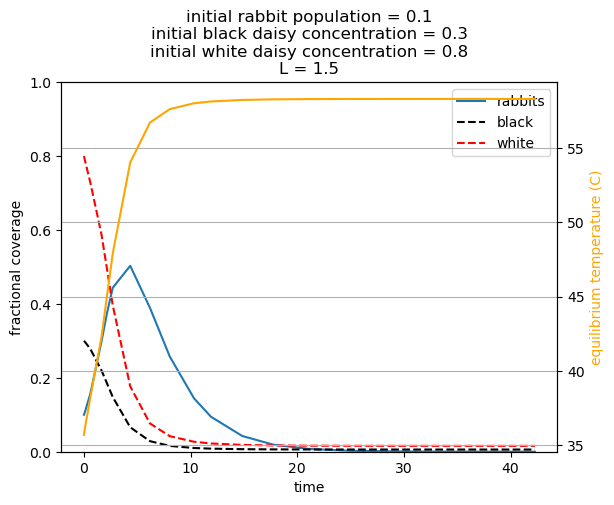

In [106]:
rabSolver3 = Integ54_rabbits('rabbits3.yaml')
r_timeVals3, r_yvals3, r_errorList3 = rabSolver3.timeloop5Err()
eTemp3 = [] 
for i in range(len(r_timeVals3)):
    w3, b3, e3 = rabSolver3.find_temp(r_yvals3[i,:2])
    eTemp3.append(e3-273.15)

fig, ax1 = plt.subplots(1,1)
ax1.plot(r_timeVals3,r_yvals3[:,2],label='rabbits')
ax1.plot(r_timeVals3,r_yvals3[:,1],'--k',label='black')
ax1.plot(r_timeVals3,r_yvals3[:,0],'--r',label='white')
ax1.legend()
ax1.set_ylabel('fractional coverage')
ax1.set_xlabel('time')
ax1.set_title('initial rabbit population = 0.1\ninitial black daisy concentration = 0.3\ninitial white daisy concentration = 0.8\nL = 1.5')
ax1.set_ylim(0,1)

ax2 = ax1.twinx()
ax2.plot(r_timeVals3,eTemp3,color='orange')
ax2.set_ylabel('equilibrium temperature (C)',color='orange')
ax2.grid()
#ax2.set_ylim(0,60)

The plot above shows the same scenario as the left plot in part 3, however, the solar fraction has not been increased to 1.5. Temperature values are shown to increase, limiting the growth of daisies and therefore affecting the population. However, adding this feedback does increase the range of habitat L values for which non-zero populations exist because the death rate of the daisies is no longer dependent on the temperature, but rather the population of rabbits. Although the population of rabbits decreases as the population of daisies decreases, an equilibrium is reached with non-zero values of daisies and rabbits, even at a much higher equilibrium temperature. Although the plot above shows that the daisy and rabbit populations are approaching zero, there is a small amount (very close to zero) of bunnies and rabbits that survive in this new steady-state.